In [4]:
# import packages
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler 
from collections import defaultdict
from collections import Counter
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Import Dataset

In [5]:
# Dataset Names
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]
# import train dataset
train_dataset = pd.read_table("Train.txt", names=col_names, sep=",") 
train_dataset = train_dataset.iloc[:,:-1] 
# import test dataset
test_dataset = pd.read_table("Test.txt", names=col_names, sep=",")
test_dataset = test_dataset.iloc[:,:-1]
print('Train Dataset: {} x {}'.format(train_dataset.shape[0], train_dataset.shape[1]))
print('Test Dataset: {} x {}'.format(test_dataset.shape[0], test_dataset.shape[1]))

Train Dataset: 125973 x 42
Test Dataset: 22544 x 42


In [6]:
attack_list = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }
# change attacks to a new field attack class
train_dataset['attack_type'] = train_dataset['attack'].apply(lambda v: attack_list[v])
test_dataset['attack_type'] = test_dataset['attack'].apply(lambda v: attack_list[v])
# remove attack field
train_dataset.drop(['attack'], axis=1, inplace=True)
test_dataset.drop(['attack'], axis=1, inplace=True)

In [7]:
# Checking the dataset statistics
train_dataset.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Field with redundant values removed
train_dataset.drop(['num_outbound_cmds'], axis=1, inplace=True)
test_dataset.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [9]:
# Statistics of Attack Type
attack_type_trainFreq = train_dataset[['attack_type']].apply(lambda x: x.value_counts())
attack_type_testFreq = test_dataset[['attack_type']].apply(lambda x: x.value_counts())
attack_type_trainFreq['percent_train'] = round((100 * attack_type_trainFreq / attack_type_trainFreq.sum()),2)
attack_type_testFreq['percent_test'] = round((100 * attack_type_testFreq / attack_type_testFreq.sum()),2)
attack_type_dist = pd.concat([attack_type_trainFreq,attack_type_testFreq], axis=1) 
attack_type_dist

,attack_type,percent_train,attack_type,percent_test
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


Text(0.5, 1.0, 'Attack Type')

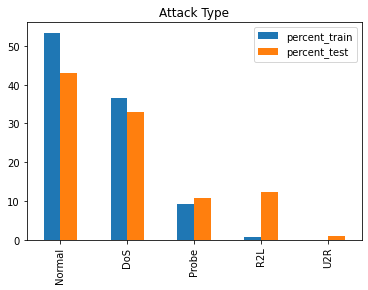

In [10]:
plot = attack_type_dist[['percent_train', 'percent_test']].plot(kind="bar")
plot.set_title("Attack Type")

### Scaling and Encoding

In [11]:
cols = train_dataset.select_dtypes(include=['float64','int64']).columns
scaler = StandardScaler()
train_fit = scaler.fit_transform(train_dataset.select_dtypes(include=['float64','int64']))
test_fit = scaler.fit_transform(test_dataset.select_dtypes(include=['float64','int64']))
train_fitdf = pd.DataFrame(train_fit, columns = cols)
test_fitdf = pd.DataFrame(test_fit, columns = cols)
# copy cat data 
train_cat = train_dataset.select_dtypes(include=['object']).copy()
test_cat = test_dataset.select_dtypes(include=['object']).copy()
# encode data
encoder = LabelEncoder()
train_cat_enc = train_cat.apply(encoder.fit_transform)
test_cat_enc = test_cat.apply(encoder.fit_transform)
enctrain = train_cat_enc.drop(['attack_type'], axis=1)
enctest = test_cat_enc.drop(['attack_type'], axis=1)
cat_Ytrain = train_cat_enc[['attack_type']].copy()
cat_Ytest = test_cat_enc[['attack_type']].copy()

### Sampling

In [12]:
train_fitdf = train_dataset.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([train_fitdf, enctrain], axis=1).columns
refclass = np.concatenate((train_fit, enctrain.values), axis=1)
X = refclass
# change to 1d array 
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)
c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Dataset (Before Resampling) {}'.format(Counter(y)))
print('Dataset (After Resampling) {}'.format(Counter(y_res)))

Dataset (Before Resampling) Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Dataset (After Resampling) Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})


### Feature Selection

In [13]:
# Use random forest classifier to find important features
rfc = RandomForestClassifier()
rfc.fit(X_res, y_res)
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':refclasscol,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
src_bytes,0.130
service,0.085
dst_host_srv_count,0.072
dst_bytes,0.063
logged_in,0.058
dst_host_serror_rate,0.056
dst_host_diff_srv_rate,0.045
srv_count,0.042
dst_host_same_src_port_rate,0.038


In [14]:
# use recursive feature elimination to select features
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_res, y_res)
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), refclasscol)]
final_features = [v for i, v in feature_map if i==True]
final_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service']

### Partitioning

In [15]:
newcol = list(refclasscol)
newcol.append('attack_type')
new_y_res = y_res[:, np.newaxis]
res_arr = np.concatenate((X_res, new_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = newcol) 
ref_test = pd.concat([test_fitdf, test_cat_enc], axis=1)
ref_test['attack_type'] = ref_test['attack_type'].astype(np.float64)
ref_test['protocol_type'] = ref_test['protocol_type'].astype(np.float64)
ref_test['flag'] = ref_test['flag'].astype(np.float64)
ref_test['service'] = ref_test['service'].astype(np.float64)

# divide attack class into two
classdict = defaultdict(list) 
attacklist = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
normalclass = [('Normal', 1.0)]
def create_classdict():
    for j, k in normalclass: 
        for i, v in attacklist: 
            restrain_set = res_df.loc[(res_df['attack_type'] == k) | (res_df['attack_type'] == v)]
            classdict[j +'_' + i].append(restrain_set)
            ref_test_set = ref_test.loc[(ref_test['attack_type'] == k) | (ref_test['attack_type'] == v)]
            classdict[j +'_' + i].append(ref_test_set)
create_classdict()
for k, v in classdict.items():
    print(k)
pretrain = classdict['Normal_DoS'][0]
pretest = classdict['Normal_DoS'][1]
grpclass = 'Normal_DoS'

Normal_DoS
Normal_Probe
Normal_R2L
Normal_U2R


### Transform Train and Test Data

In [16]:
enc = OneHotEncoder(handle_unknown = 'ignore')
Xresdf = pretrain 
newtest = pretest
Xresdfnew = Xresdf[final_features]
Xresdfnum = Xresdfnew.drop(['service'], axis=1)
Xresdfcat = Xresdfnew[['service']].copy()
Xtest_features = newtest[final_features]
Xtestdfnum = Xtest_features.drop(['service'], axis=1)
Xtest_cat_enc = Xtest_features[['service']].copy()
enc.fit(Xresdfcat)

# Transform dataset
X_train_1hotenc = enc.transform(Xresdfcat).toarray()
X_test_1hotenc = enc.transform(Xtest_cat_enc).toarray()

X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1) 

y_train = Xresdf[['attack_type']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)

y_test = newtest[['attack_type']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)

### Train Models

In [17]:
# K Neighbors Classifier
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 
# Decision Tree Classifier
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)
# Gaussian Naive Bayes
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
# Logistic Regression
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [18]:
models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

### Evaluate Models

In [19]:
for i, v in models:
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print('\n==> Model: {}'.format(i), "\n")
    print("Confusion matrix:" "\n", confusion_matrix, "\n")
    print("Performance Scores:" "\n", classification, "\n")  
    print("Accuracy:" "\n", accuracy, "\n")   


==> Model: Naive Baye Classifier 

Confusion matrix:
 [[65087  2256]
 [  976 66367]] 

Performance Scores:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     67343
         1.0       0.97      0.99      0.98     67343

    accuracy                           0.98    134686
   macro avg       0.98      0.98      0.98    134686
weighted avg       0.98      0.98      0.98    134686
 

Accuracy:
 0.976003445049968 


==> Model: Decision Tree Classifier 

Confusion matrix:
 [[67343     0]
 [    6 67337]] 

Performance Scores:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67343
         1.0       1.00      1.00      1.00     67343

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686
 

Accuracy:
 0.999955451940068 


==> Model: KNeighborsClassifier 

Confusion matrix:
 [[673

### Test Models

In [20]:
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print('\n==> Model: {}'.format(i), "\n")
    print("Confusion matrix:" "\n", confusion_matrix, "\n")
    print("Performance Scores:" "\n", classification, "\n")  
    print("Accuracy:" "\n", accuracy, "\n")   



==> Model: Naive Baye Classifier 

Confusion matrix:
 [[5447 2011]
 [ 844 8867]] 

Performance Scores:
               precision    recall  f1-score   support

         0.0       0.87      0.73      0.79      7458
         1.0       0.82      0.91      0.86      9711

    accuracy                           0.83     17169
   macro avg       0.84      0.82      0.83     17169
weighted avg       0.84      0.83      0.83     17169
 

Accuracy:
 0.8337119226512901 


==> Model: Decision Tree Classifier 

Confusion matrix:
 [[6576  882]
 [9553  158]] 

Performance Scores:
               precision    recall  f1-score   support

         0.0       0.41      0.88      0.56      7458
         1.0       0.15      0.02      0.03      9711

    accuracy                           0.39     17169
   macro avg       0.28      0.45      0.29     17169
weighted avg       0.26      0.39      0.26     17169
 

Accuracy:
 0.39221853340322677 


==> Model: KNeighborsClassifier 

Confusion matrix:
 [[5760 169